In [232]:
import numpy as np 
from kmcluster.core.utils import fetch_pt7_data
from kmcluster.core.data import sparse_to_mat
from kmcluster.core.data import energy_to_rates
from kmcluster.core.intialize import random_init, boltz
from kmcluster.core.viz import graph_trajectories_static
from kmcluster.core.cluster import (
    plot_coms_cdlib,
    plot_affinity_at_temp,
)
#import expm
from scipy.linalg import expm
# supress warnings
import warnings

warnings.filterwarnings("ignore")

In [252]:
# get data
T = 100 # temperature
huan_all, huan_rel = huan_bars = fetch_pt7_data()
# generate boltzman distribution
boltz_dist = boltz(size=10000, energies=huan_rel, T=T)
energies_huan_mat = sparse_to_mat(huan_all)

In [254]:

rate_mat = energy_to_rates(energies_huan_mat, T, scale=1)
# convert rate matrix to transition matrix
transition_mat = rate_mat / np.sum(rate_mat, axis=1)[:, np.newaxis]
# convert rate matrix to rate Matrix where diagonal is -1 * sum of column
# Note: This is required for the continuous markov approximations
rate_mat_diag_neg = rate_mat - np.diag(np.sum(rate_mat, axis=1))

In [ ]:
# get eigenvalues and eigenvectors of transition_mat 
eigvals, eigvecs = np.linalg.eig(transition_mat)
# find stationary distribution
pi = eigvecs[:, np.argmax(eigvals.real)]
# normalize stationary distribution
pi = pi / np.sum(pi)
# filter out states with low probability
pi[pi < 1e-3] = 0

# this is a t --> inifinity
#print("Stationary distribution: ", pi.real)
#print("States visited by stationary distribution: ", np.nonzero(pi)[0])
# this is zero indexed !!!

Stationary distribution:  [0.00297774 0.05728418 0.00297774 0.05728418 0.05728418 0.05728418
 0.05728418 0.05728418 0.00297774 0.05728418 0.00297774 0.00297774
 0.05728416 0.05728418 0.05728418 0.05728418 0.05728418 0.05728418
 0.05728418 0.00297774 0.00297774 0.05728418 0.05728418 0.00297774
 0.05728418 0.00234702]
States visited by stationary distribution:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


In [ ]:
# get eigenvalues and eigenvectors of rate matrix
eigvals, eigvecs = np.linalg.eig(rate_mat_diag_neg)
# sort eigenvalues and eigenvectors
idx = eigvals.argsort()[::-1]
# make any eigenvalues close to zero zero
#eigvals[eigvals] = 0
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

eig_mat = np.diag(eigvals)
eig_vec_mat = eigvecs

eig_vec_mat_inv = np.linalg.inv(eig_vec_mat)
# if this give you an singular matrix error use np.linalg.pinv instead

In [256]:
# These are just different propagation equations. Some work better than others. 

def taylor_expand_prop(eig_mat, t, order = 3, filter = True):
    # initialize matrix
    if filter:
        eig_mat[ np.abs(eig_mat) < 1e-9] = 0
    taylor_mat = np.zeros_like(eig_mat)
    # loop over order
    for i in range(order):
        # add to matrix
        taylor_mat += np.linalg.matrix_power(t * eig_mat, i) / np.math.factorial(i)
    return taylor_mat

def propagate(a_0, time, eig_mat, eigvecs, inv_eigvecs, order = 3, filter = False):
    """
    a_0: initial distribution
    time: time to propagate
    eigvecs: eigenvectors of rate matrix
    inv_eigvecs: inverse of eigenvectors of rate matrix
    order: order of taylor expansion
    """
    # initialize matrix
    prop_mat = np.zeros_like(eigvecs)
    # loop over order
    taylor_mat = taylor_expand_prop(eig_mat, time, order, filter=filter)
    # multiply by eigenvectors
    prop_mat = np.matmul(eigvecs, np.matmul(taylor_mat, inv_eigvecs))
    # multiply by initial distribution
    prop_mat = np.matmul(prop_mat, a_0)
    return prop_mat

def propagate_alt(a_0, time, eig_mat, eigvecs, inv_eigvecs, order = 3):
    """
    a_0: initial distribution
    time: time to propagate
    eigvecs: eigenvectors of rate matrix
    inv_eigvecs: inverse of eigenvectors of rate matrix
    order: order of taylor expansion
    """
    ret_mat = np.zeros_like(a_0, dtype=np.complex128)
    # loop over all eigenvectors
    for i in range(len(eigvecs)):
        # get eigenvalue
        eig_val = eig_mat[i, i]
        # get eigenvector
        eig_vec = eigvecs[:, i]
        # get inverse eigenvector
        inv_eig_vec = inv_eigvecs[i, :]
        # get taylor expansion
        #print(inv_eig_vec * a_0 * np.exp(-1 * eig_val * time) * eig_vec)
        ret_mat += inv_eig_vec * a_0 * np.exp(-1 * eig_val * time) * eig_vec
    
    return ret_mat


def propagate_base(a_0, time, rates):
    exp_term = expm(rates * time)
    # normalize
    exp_term = exp_term / np.sum(exp_term,  axis=0)
    return np.dot(exp_term, a_0)


In [257]:
# Standard pop, I'm just going to convert to proportion here
boltz_dist = boltz(size=10000, energies=huan_rel, T=T)
init_dist = boltz_dist.get_init_populations()
init_dist_prop = init_dist / np.sum(init_dist)

In [264]:
# second arguement is time
new_state = propagate_base(init_dist_prop, 10-8, rate_mat_diag_neg)

26 26
1.0000000000000002


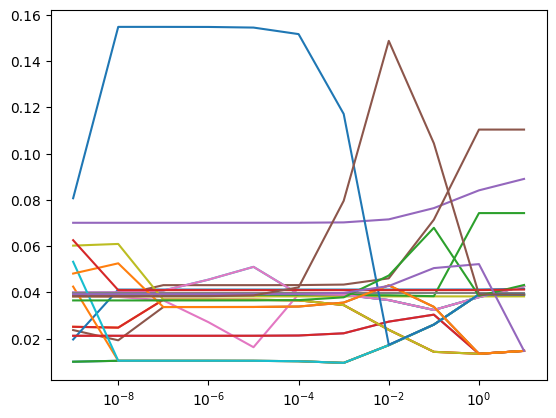

In [278]:
samples = [10e-10, 10e-9, 10e-8, 10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0]
prop_dict = {}
for sample in samples:
    prop_dict[sample] = propagate_base(init_dist_prop, sample, rate_mat_diag_neg)

# plot the results

import matplotlib.pyplot as plt

for i in range(len(prop_dict[10e-10])):
    prop_time = [prop_dict[sample][i] for sample in samples]
    plt.plot(samples, prop_time, label=i)

plt.xscale("log")
